In [2]:
import copy
import geopandas
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [3]:
counties_gcs = geopandas.read_file("counties.geojson")

In [4]:
#Q1
len(counties_gcs)

72

<AxesSubplot:>

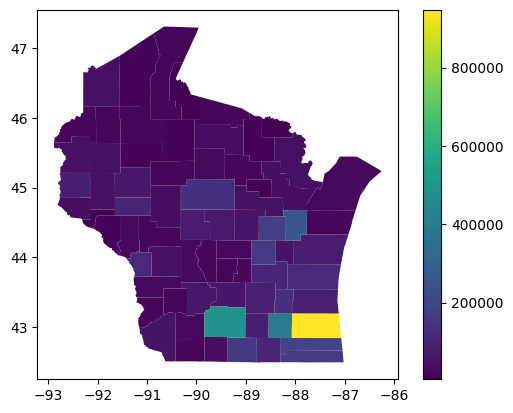

In [5]:
#Q2
counties_gcs.plot('POP100', legend = True)

In [6]:
conn = sqlite3.connect("counties_tracts.db")
arealand_df = pd.read_sql("""SELECT NAME, AREALAND FROM counties""", conn)
counties_gcs = counties_gcs.merge(arealand_df, on='NAME', how='left')
train, test = train_test_split(counties_gcs, test_size=0.25, random_state=250)

In [7]:
#Q3
list(test["NAME"])

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [8]:
#Q4
model = LinearRegression()
model.fit(train[["AREALAND"]], train["POP100"])
model.score(test[["AREALAND"]], test["POP100"])

0.016720430179409274

In [9]:
#Q5
sq_meters = 400 * 2.59 * 1e6
model.predict(pd.DataFrame({"AREALAND": [sq_meters]}))[0]

90000.07422783462

In [10]:
hu100_df = pd.read_sql("""
  SELECT counties.NAME, SUM(HU100) AS HU100
  FROM tracts LEFT JOIN counties 
  ON tracts.COUNTY = counties.COUNTY
  GROUP BY counties.NAME""", conn)
counties_gcs = counties_gcs.merge(hu100_df, on='NAME', how='left')
train, test = train_test_split(counties_gcs, test_size=0.25, random_state=250)

In [11]:
#Q6
list(test["NAME"])

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [12]:
#Q7
dict(test[["NAME", "HU100"]].set_index("NAME").to_dict()['HU100'])

{'Dane County': 216022,
 'Juneau County': 14669,
 'Taylor County': 10582,
 'Vilas County': 25116,
 'Rusk County': 8883,
 'Price County': 11120,
 'Jackson County': 9727,
 'Waushara County': 14843,
 'Pepin County': 3579,
 'Douglas County': 22825,
 'Ashland County': 9656,
 'Milwaukee County': 418053,
 'Waupaca County': 25396,
 'Richland County': 8868,
 'Lafayette County': 7230,
 'Washburn County': 12979,
 'Dunn County': 17964,
 'Bayfield County': 12999}

In [13]:
#Q8
model = LinearRegression()
result = cross_val_score(model, train[["HU100"]], train["POP100"], cv=5)
np.mean(result)

0.9739348181232653

In [14]:
#Q9
np.std(result)

0.01693954236334351

In [15]:
#Q10
model.fit(train[["HU100"]], train["POP100"])
coef = round(model.coef_[0], 2)
y_int = round(model.intercept_, 2)
f"POP100 = {coef}*HU100 + {y_int}"

'POP100 = 2.47*HU100 + -9276.89'

(-18537.0, 438843.0, -55045.01361345532, 1074232.870517802)

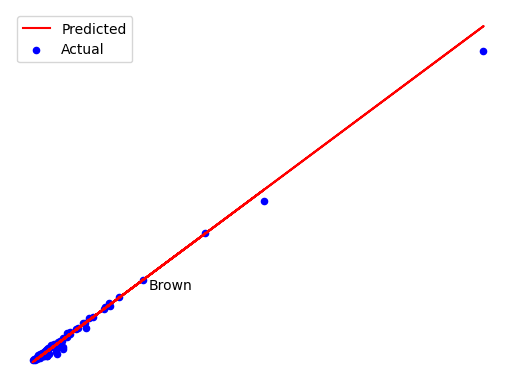

In [16]:
#Q11
plot_df = copy.deepcopy(counties_gcs)
plot_df["pred"] = model.predict(plot_df[["HU100"]])

brown_county = plot_df[plot_df["NAME"] == "Brown County"]
x_loc = int(brown_county["HU100"])
y_loc = int(brown_county["POP100"])

ax = plot_df.plot.line(x="HU100", y="pred", color="red")
plot = plot_df.plot.scatter(x="HU100", y="POP100", color="blue", ax=ax)
plot.text(x_loc+0.05e5, y_loc-0.03e6, "Brown", color="black")
plot.legend(["Predicted","Actual"])
plot.axis('off')

In [17]:
#Q12
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])
((A >= 3) & (A <= 6)).astype(int).sum()

8

In [18]:
c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

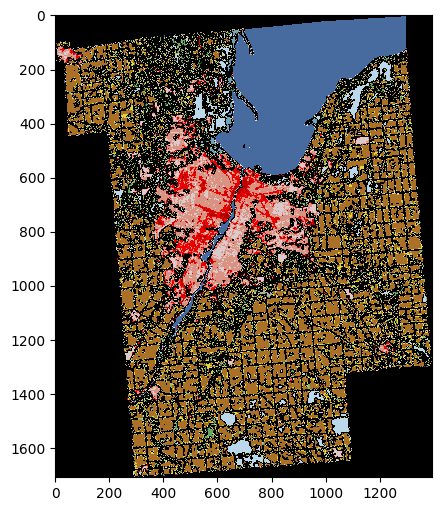

In [19]:
#Q13
land = rasterio.open("zip://../p6/land.zip!wi.tif")
brown_county = counties_gcs[counties_gcs["NAME"] == "Brown County"]
matrix, _ = mask(land, brown_county.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(matrix, vmin=0, vmax=255, cmap=custom_cmap)

In [20]:
#Q14
water = (matrix == land_use["open_water"]).astype(int).sum()
all_land = (matrix != 0).astype(int).sum()
water / all_land

0.13797526789725206

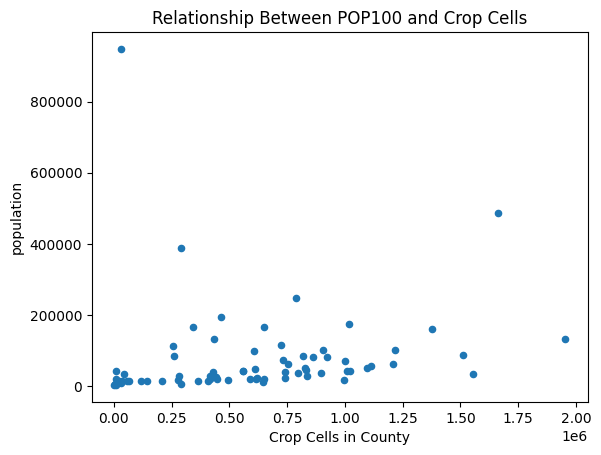

In [21]:
#Q15
crops_df = copy.deepcopy(counties_gcs)
crops_df['CROP'] = 0
names = list(crops_df['NAME'])

for name in names:
    county = crops_df[crops_df["NAME"] == name]
    matrix, _ = mask(land, county.to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    crops_df.loc[crops_df['NAME'] == name, 'CROP'] = (matrix == land_use["crops"]).astype(int).sum()
    
ax = crops_df.plot.scatter(x="CROP", y="POP100")
plt.title("Relationship Between POP100 and Crop Cells")
ax.set_xlabel("Crop Cells in County")
ax.set_ylabel("population")
plt.show()

In [22]:
tracts = geopandas.read_file("tracts.shp")
areas = list(tracts['GEOID'])

for feature in land_use:
    tracts[feature] = 0
for area in areas:
    area_spec = tracts[tracts["GEOID"] == area]
    matrix, _ = mask(land, area_spec.to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    for feature in land_use:
        feature_count = (matrix == land_use[feature]).astype(int).sum()
        tracts.loc[tracts['GEOID'] == area, feature] = feature_count

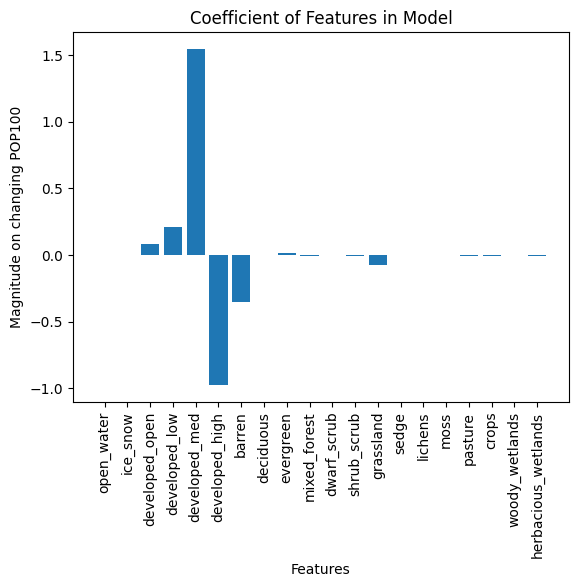

In [23]:
#Q16
train, test = train_test_split(tracts, test_size=0.20, random_state=300)
model = LinearRegression()
features = list(land_use.keys())
model.fit(train[features], train["POP100"])

ax = plt.bar(features, model.coef_)
plt.title("Coefficient of Features in Model")
plt.xlabel("Features")
plt.ylabel("Magnitude on changing POP100")
plt.xticks(rotation=90)
plt.show()

# The bar graph tells me that one unit change in each feature specified at x-axis is 
# related to how much change in POP100(population) of a county. For example: if there 
# one more unit of the county used for developed_med, the population of the county will
# increase approximately 1.5 units of people. In the bar graph, we can see that there 
# are several features not related to population or those features do not have data. 
# Among those features, developed_med takes the biggest steak on affctting a county's 
# population. The graph can help me identity which features should be used to make a 
# better model on predicting county's population in Part 2.

In [24]:
model_1 = LinearRegression()
features_1 = ['developed_low', 'developed_med', 'developed_high', 'barren']
result_1 = cross_val_score(model_1, train[features_1], train["POP100"], cv=5)
stat_1 = [np.mean(result_1), np.std(result_1)**2]

model_2 = Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("lr", LinearRegression())
])
features_2 = ['developed_med', 'developed_high']
result_2 = cross_val_score(model_2, train[features_2], train["POP100"])
stat_2 = [np.mean(result_2), np.std(result_2)**2]

data = {
    'model': [1, 2],
    'mean of cross validation score': [stat_1[0], stat_2[0]],
    'variance of cross validation score': [stat_1[1], stat_2[1]]
}

df = pd.DataFrame(data)
df.style.hide_index()

/tmp/ipykernel_5686/2919879588.py:21: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  df.style.hide_index()


model,mean of cross validation score,variance of cross validation score
1,0.422671,0.003170
2,0.428571,0.002883


In [25]:
#Q17

# I blieve that model 2 is better for this prediction task. Because model 2 has a higher mean 
# and lower variance of cross validation score than model 1. Since model 2 use sklearn Pipeline 
# including PolynomialFeatures() transformers, it can help use predict more accurately.
model_2.fit(train[features_2], train["POP100"])
model_2.score(test[features_2], test["POP100"])

0.4329904065699718